In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reading and Importing data

In [2]:
orders = pd.read_csv('/Users/abay/Downloads/task_2_data/orders.csv')
payments = pd.read_csv('/Users/abay/Downloads/task_2_data/payments.csv')
plan = pd.read_csv('/Users/abay/Downloads/task_2_data/plan.csv')

# Preparing and Cleaning Data 

*Converting to the df format*

In [3]:
orders_df = pd.DataFrame(orders)
payments_df = pd.DataFrame(payments)
plan_df = pd.DataFrame(plan)

In [4]:
print(orders_df.isna().sum(),payments_df.isna().sum(), plan_df.isna().sum(), sep='\n')

order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64
order_id    0
paid_at     0
paid_sum    0
dtype: int64
order_id          0
plan_at           0
plan_sum_total    0
dtype: int64


Only closed_at column in orders_df has NaN values, so if closed_at consists of 5-10% of NaN values rows we cnn drop it , if it 's at least around 20% we cant drop it

In [5]:
percent_nan = orders_df['closed_at'].isna().mean() * 100
print(f"{percent_nan}%")

16.639161943029347%


We better not drop this NaN rows but fill them by mode

In [6]:
closed_mode = orders_df['closed_at'].mode()[0] 
orders_df['closed_at'] = orders_df['closed_at'].fillna(closed_mode)
orders_df.isna().sum()

order_id      0
created_at    0
put_at        0
closed_at     0
issued_sum    0
dtype: int64

*.mode()* returns a Series, not a single value. We need to extract the first value from it using *[0]*

*From String Date time into Python Date time object*

In [7]:
plan_df['plan_at'] = pd.to_datetime(plan_df['plan_at'])
payments_df['paid_at'] = pd.to_datetime(payments_df['paid_at'])

*We will take delay payments in days* : the difference between plan_at - planned payment date and paid_at - actual payment date and the difference of plan_sum_total - planned sum and paid_sum - actual sum paid

Then we will convert Boolean types into integers using *.astype()* because it makes it easier to interpret and do statistics




In [8]:
delay_df = pd.DataFrame()

delay_df['overdue_days'] = (plan_df['plan_at'] - payments_df['paid_at']).dt.days
delay_df['overdue_bool'] = (delay_df['overdue_days']>0).astype(int)
delay_df['debt'] = plan_df['plan_sum_total'] - payments_df['paid_sum']
delay_df['debt_bool'] = (delay_df['debt']>0).astype(int)

delay_df.isna().sum()

overdue_days    276998
overdue_bool         0
debt            276998
debt_bool            0
dtype: int64

We can see the same amount of Nan values both in *overdue_days* and *debt*. 

We need check how much do they make up of the total rows in their columns

In [9]:
overdue_nan = delay_df['overdue_days'].isna().mean() * 100
debt_nan = delay_df['debt'].isna().mean() * 100

print(f"{overdue_nan}% of NaN rows in overdue_days column")
print(f"{debt_nan}% of NaN rows in debt column")

65.90765248095326% of NaN rows in overdue_days column
65.90765248095326% of NaN rows in debt column


Since, more than the half of data are missing, it's not right thing to drop them, instead we need to fill them either with *mode* or *avg*. 

We cant replace NaN values with *mode*, because the 66% of column are NaN. So, we will replace NaN values with *avg value*

In [10]:
debt_avg = delay_df['debt'].mean()
overdue_avg = delay_df['overdue_days'].mean()

delay_df['overdue_days'] = delay_df['overdue_days'].fillna(overdue_avg)
delay_df['debt'] = delay_df['debt'].fillna(debt_avg)

# Analysis of delay dynamics

1) *Loan Issuance Delays*

Trend Analysis: How has the average issuance delay changed over time?

In [11]:
plan_df['plan_at'] = pd.to_datetime(plan_df['plan_at'])
delay_df['year'] = plan_df['plan_at'].dt.year

delay_df.isna().sum()

overdue_days    0
overdue_bool    0
debt            0
debt_bool       0
year            0
dtype: int64

### Plotting the trends

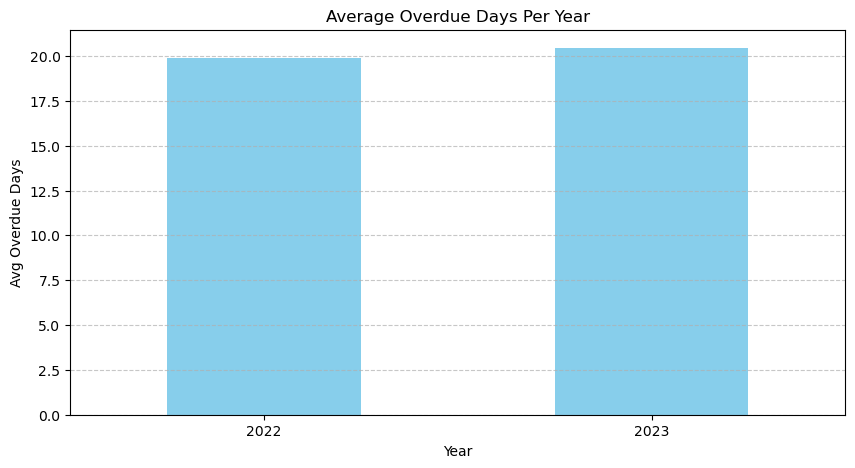

In [12]:
overdue_trend = delay_df.groupby('year')['overdue_days'].mean()

# Plot the trend
overdue_trend.plot(kind='bar', figsize=(10, 5), color='skyblue', title="Average Overdue Days Per Year")

# Labels
plt.xlabel("Year")
plt.ylabel("Avg Overdue Days")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better visualization

plt.show()

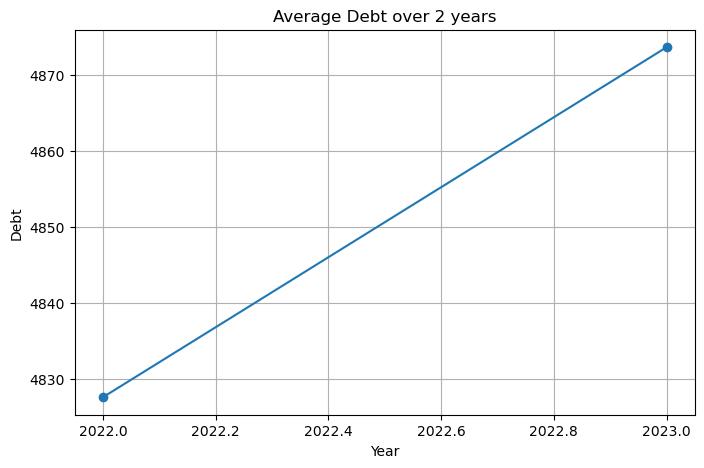

In [13]:
debt_trend = delay_df.groupby('year')['debt'].mean()

debt_trend.plot(kind='line', marker='o', figsize=(8,5), title='Average Debt over 2 years')

plt.xlabel('Year')
plt.ylabel('Debt')
plt.grid(True)
plt.show()

2) *Payment Delays*

Late Payment Rate: What percentage of payments are late in 2022(monthes)?

In [14]:
delay_2022 = delay_df[delay_df['year'] == 2022]
delay_2022

,overdue_days,overdue_bool,debt,debt_bool,year
0,-1.000000,0,3100.000000,1,2022
1,29.000000,1,8380.000000,1,2022
2,59.000000,1,7970.000000,1,2022
3,89.000000,1,12040.000000,1,2022
4,119.000000,1,7510.000000,1,2022
...,...,...,...,...,...
420273,19.938325,0,4832.804358,0,2022
420274,19.938325,0,4832.804358,0,2022
420275,19.938325,0,4832.804358,0,2022
420276,19.938325,0,4832.804358,0,2022


In [15]:
delay_2022['late_payment'] = (delay_2022['overdue_days']>0).astype(int) # 1 - there's delay payment, 0 - there's not
print(delay_2022['late_payment'].value_counts())
print(f"{delay_2022['late_payment'].mean()*100}%")

late_payment
1    313645
0     59120
Name: count, dtype: int64
84.14014191246495%


/var/folders/vw/42wt165574b7245nzwcs1t4w0000gn/T/ipykernel_43295/1422811365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_2022['late_payment'] = (delay_2022['overdue_days']>0).astype(int) # 1 - there's delay payment, 0 - there's not


In [16]:
late_payment_trend = delay_2022.groupby('year')['late_payment'].mean()
print(f"{late_payment_trend * 100}% of payments are delayed")

year
2022    84.140142
Name: late_payment, dtype: float64% of payments are delayed


Severity of Delays: How many payments are delayed by 30+ days?

In [17]:
severe_delays = delay_2022[delay_2022['overdue_days']>=30].shape[0]
severe_delays

63285

Out of 372765 payments, 63285 payments were delayed by 30+ days

In [18]:
delay_2022

,overdue_days,overdue_bool,debt,debt_bool,year,late_payment
0,-1.000000,0,3100.000000,1,2022,0
1,29.000000,1,8380.000000,1,2022,1
2,59.000000,1,7970.000000,1,2022,1
3,89.000000,1,12040.000000,1,2022,1
4,119.000000,1,7510.000000,1,2022,1
...,...,...,...,...,...,...
420273,19.938325,0,4832.804358,0,2022,1
420274,19.938325,0,4832.804358,0,2022,1
420275,19.938325,0,4832.804358,0,2022,1
420276,19.938325,0,4832.804358,0,2022,1


3) *Factors Affecting Delays*

Loan Amount: Do larger loans have longer payment delays?


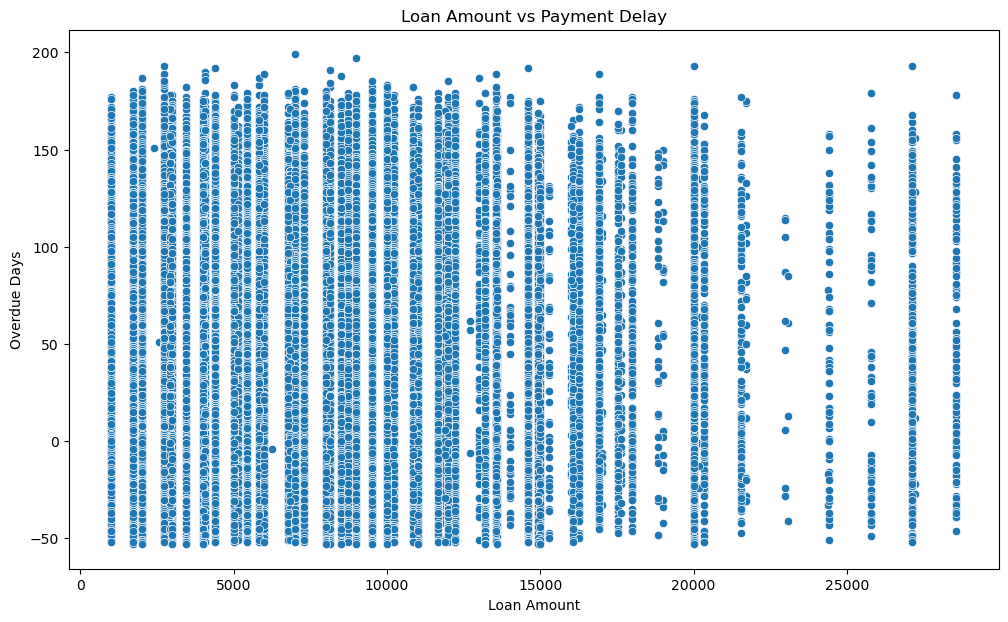

In [19]:
plt.figure(figsize=(12,7))
sns.scatterplot(x=orders_df['issued_sum'], y=delay_2022['overdue_days'])
plt.xlabel('Loan Amount')
plt.ylabel('Overdue Days')
plt.title("Loan Amount vs Payment Delay")
plt.show()

In [20]:
corr = orders_df['issued_sum'].corr(delay_2022['overdue_days'])
print(corr)

-0.0070160395080629545


*The correlation coefficien -0.007 between issued_sum (loan amount issued) and overdue_days (payment delay in 2022) suggests almost no relationship between the two variables.*